In [1]:
#Reference tutorial: https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/advanced_circuits_algorithms/Quantum_Fourier_Transform/Quantum_Fourier_Transform.ipynb

In [2]:
from braket.circuits import circuit
from braket.circuits import Circuit

from braket.devices import LocalSimulator

import numpy as np

import matplotlib.pyplot as plt

plt.style.use("dark_background")

### Functions

In [3]:
# Define function to build Quantum Fourier Transform (QFT) circuit
def build_qft_circuit(qubits_count):
    """Build Quantum Fourier Transform (QFT) circuit.

    Args:
        qubits_count (int): Number of qubits.

    Returns:
        Circuit: QFT circuit.
    """
    qubits = list(range(qubits_count))
    circuit = Circuit()

    # Add Hadamards and Controlled RZ gates
    for target_qubit in qubits:
        for control_qubit in range(target_qubit, qubits_count):
            if control_qubit == target_qubit:
                circuit.h(control_qubit)
            else:
                theta = np.pi / 2 ** (control_qubit - target_qubit)
                circuit.cphaseshift(control_qubit, target_qubit, theta)

    # Add SWAP gates
    for qubit_index in range(qubits_count // 2):
        reversed_qubit_index = -qubit_index - 1
        circuit.swap(qubits[qubit_index], qubits[reversed_qubit_index])

    return circuit

In [4]:
# Define function to build initial state circuit
def build_initial_state_circuit(qubits_count):
    """Build circuit to prepare initial state.

    Args:
        qubits_count (int): Number of qubits.

    Returns:
        Circuit: Circuit for initial state preparation.
    """
    qubits = list(range(qubits_count))
    circuit = Circuit()

    circuit.h(qubits) #for uniform distribution
    # circuit.x(qubits) #for starting from |111..> state
    return circuit

In [5]:
# Define constants
QUBITS_COUNT = 4

# Build initial state circuit
initial_state_circuit = build_initial_state_circuit(QUBITS_COUNT)
print(initial_state_circuit)

T  : |0|
        
q0 : -H-
        
q1 : -H-
        
q2 : -H-
        
q3 : -H-

T  : |0|


## Test 1: QFT on |++..+>

In [6]:
# Build QFT circuit
qft_circuit = build_qft_circuit(QUBITS_COUNT)
print(qft_circuit)

T  : |0|     1     |      2      |           3           |      4      |     5     | 6  | 7  |
                                                                                              
q0 : -H-PHASE(1.57)-PHASE(0.79)---PHASE(0.39)--------------------------------------------SWAP-
        |           |             |                                                      |    
q1 : ---C-----------|-----------H-|-----------PHASE(1.57)-PHASE(0.79)---------------SWAP-|----
                    |             |           |           |                         |    |    
q2 : ---------------C-------------|-----------C-----------|-----------H-PHASE(1.57)-SWAP-|----
                                  |                       |             |                |    
q3 : -----------------------------C-----------------------C-------------C-----------H----SWAP-

T  : |0|     1     |      2      |           3           |      4      |     5     | 6  | 7  |


In [7]:
# Build inverted QFT circuit
inverted_qft_circuit = qft_circuit.adjoint()
print(inverted_qft_circuit)

T  : |    0    |1|   2   |    3    |       4       |    5    |   6   |7|
                                                                        
q0 : ------SWAP-----------------------------(-0.39)---(-0.79)-(-1.57)-H-
           |                                |         |       |         
q1 : -SWAP-|----------------(-0.79)-(-1.57)-|-------H-|-------(-1.57)---
      |    |                |       |       |         |                 
q2 : -SWAP-|------(-1.57)-H-|-------(-1.57)-|---------(-0.79)-----------
           |      |         |               |                           
q3 : ------SWAP-H-(-1.57)---(-0.79)---------(-0.39)---------------------

T  : |    0    |1|   2   |    3    |       4       |    5    |   6   |7|


In [8]:
# Compose circuits
circuit = Circuit()
circuit.add_circuit(initial_state_circuit)
circuit.add_circuit(qft_circuit)

# Add result types
circuit.state_vector()
circuit.probability()

print(circuit)

T  : |0|1|     2     |      3      |           4           |      5      |     6     | 7  | 8  |Result Types|
                                                                                                             
q0 : -H-H-PHASE(1.57)-PHASE(0.79)---PHASE(0.39)--------------------------------------------SWAP-Probability--
          |           |             |                                                      |    |            
q1 : -H---C-----------|-----------H-|-----------PHASE(1.57)-PHASE(0.79)---------------SWAP-|----Probability--
                      |             |           |           |                         |    |    |            
q2 : -H---------------C-------------|-----------C-----------|-----------H-PHASE(1.57)-SWAP-|----Probability--
                                    |                       |             |                |    |            
q3 : -H-----------------------------C-----------------------C-------------C-----------H----SWAP-Probability--

T  : |0|1

In [9]:

# Run simulation
device = LocalSimulator()
task = device.run(circuit, shots=0)
result = task.result()

In [10]:
# Retrieve state vector and probabilities
state_vector, probabilities = result.values
print(state_vector.round(3))
print(probabilities.round(3))


[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j
  0.-0.j  0.-0.j  0.-0.j -0.+0.j  0.-0.j  0.-0.j  0.-0.j]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
# Define state format for printing
state_format = f"0{QUBITS_COUNT}b"

# List all possible states
states = list(range(2 ** QUBITS_COUNT))
states_strings = [f"{state:{state_format}}" for state in states]

states_strings[:8]


['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111']

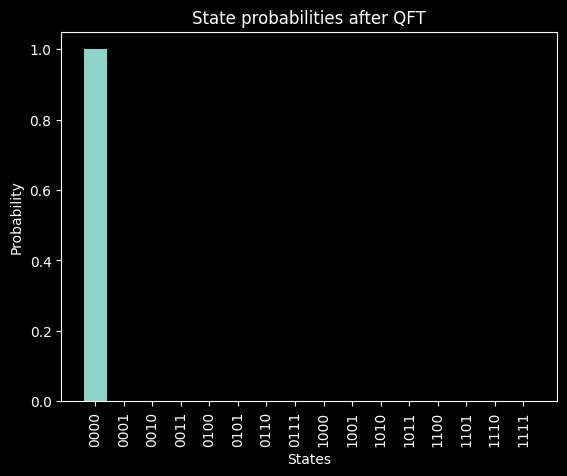

In [12]:
# Plot probabilities
plt.bar(states_strings, probabilities)
plt.title("State probabilities after QFT")
plt.xlabel("States")
plt.ylabel("Probability")
plt.xticks(rotation=90)
plt.show()


## Test 2: QFT and Inverse QFT cancel each other out.

In [13]:
#test that the circuit is working:
def test_qft(num_qubits, device = LocalSimulator()):
    """Test the QFT circuit.

    Args:
        num_qubits (int): Number of qubits.
        device (LocalSimulator): Braket device to run the circuit.

    Returns:
        tuple: Tuple containing state vector and probabilities.
    """

    qft_circuit = build_qft_circuit(num_qubits)
    inverted_qft_circuit = qft_circuit.adjoint()

    # Compose circuits
    circuit = Circuit()
    circuit.add_circuit(qft_circuit)
    circuit.add_circuit(inverted_qft_circuit)

    # Add result types
    circuit.state_vector()
    circuit.probability()

    # Run the QFT on 3 circuits with all zeros input
    task = device.run(circuit, shots=0)
    result = task.result()
    state_vector, probs_values = result.values

    # format state vector for output
    state_vec_pretty = np.round(state_vector, decimals=3)
    state_vec_pretty = [ampl if np.abs(ampl) > 10**(-5) else 0 for ampl in state_vec_pretty]

    # bitstrings
    format_bitstring = '{0:0' + str(num_qubits) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # Print the output state vector
    print('Exact statevector:\n', state_vec_pretty)

    # plot probabilities
    plt.bar(bitstring_keys, probs_values)
    plt.xlabel('bitstrings')
    plt.ylabel('probability')
    plt.xticks(rotation=90)
    plt.title('Probability distribution after QFT and IQFT')
    plt.show()